In [5]:
%matplotlib inline

In [66]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import itertools
# mpl.use('Agg')
import seaborn as sns

from graph_tool.draw import sfdp_layout, graph_draw
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score

from helpers import infected_nodes
from graph_helpers import load_graph_by_name
from viz_helpers import lattice_node_pos, set_cycler, smooth

In [12]:
graph = 'grqc-sto'
sampling_method = 'loop_erased'
obs_frac = "0.2"
cascade_frac = '0.025'
obs_method = 'leaves'
dataset_id = '{}-mic-s{}-o{}-om{}'.format(graph, cascade_frac, obs_frac, obs_method)
cascade_dir = 'cascade-weighted/{}'.format(dataset_id)
query_path = 'outputs/queries-weighted/{}/{}/'.format(dataset_id, sampling_method)
inf_probas_path = 'outputs/inf_probas-weighted/{}/{}/'.format(dataset_id, sampling_method)
fig_root_dir = 'figs/infection-probas-after-queries/{}'.format(dataset_id)

In [20]:
def get_query_hit_states(method):
    """return 2D list"""
    queries_states = []
    for cascade_id in range(96):
        cascade_path = 'cascade-weighted/{}/{}.pkl'.format(dataset_id, cascade_id)
        obs, c = pkl.load(open(cascade_path, 'rb'))[:2]
        inf_nodes = set(infected_nodes(c))
        # inf_probas_pathbas_list = pkl.load(open(inf_probas_path + method + '/{}.pkl'.format(cascade_id), 'rb'))
        queries, _ = pkl.load(open(query_path + method + '/{}.pkl'.format(cascade_id), 'rb'))
        queries_states.append(list(map(inf_nodes.__contains__, queries)))
    return queries_states

In [21]:
def query_strategy_hit_ratio(method):
    states = get_query_hit_states(method)
    states = np.array(list(itertools.chain(*states)))
    return states.sum() / len(states)


In [22]:
methods = ['random', 'pagerank', 'entropy', 'prediction_error', 'mutual-info']
# , 'weighted_prediction_error'
for m in methods:
    print('{}, hit ratio: {}'.format(m, query_strategy_hit_ratio(m)))

random, hit ratio: 0.023875
pagerank, hit ratio: 0.19885416666666667
entropy, hit ratio: 0.10945833333333334
prediction_error, hit ratio: 0.13982854906982534
mutual-info, hit ratio: 0.074467855679441


In [54]:
max_queries = 500

In [61]:
hit_ratio_ts = {}
for method in methods:
    print(method)
    states = get_query_hit_states(method)
    n_queries = list(map(len, states))
    for s in states:
        s += [s[-1]] * (max_queries - len(s))
    states = np.array(states)  
    hit_ratio_ts[method] = np.mean(states, axis=0)

random
pagerank
entropy
prediction_error
mutual-info


In [ ]:
plt.style.use('paper')

ValueError: x and y must have same first dimension

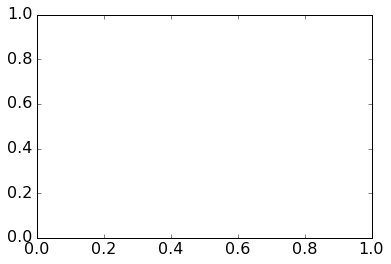

In [72]:
fig, ax = plt.subplots(1, 1)
x = np.arange(0, max_queries, 5)
set_cycler(ax)
for method in methods:
    ts = hit_ratio_ts[method]
    ax.plot(x[::25], smooth(ts)[::25])